In [0]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg

import os


In [0]:
print('Loading MNIST dataset')
n_class = 10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

NUM_TRAIN_EXAMPLES=X_train.shape[0]

batch_size = 128
n_epochs = 20
lr = 1e-3
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


In [0]:
def build_model():

  kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

  model= keras.Sequential([
                           tfp.layers.Convolution2DFlipout(20, kernel_size=(5,5), strides=(1, 1),padding="same", kernel_divergence_fn=kl_divergence_function, activation='relu'),
                           layers.MaxPool2D( pool_size = (2, 2),strides =  (2, 2)),
                           tfp.layers.Convolution2DFlipout(50, kernel_size=(5,5),strides=(1, 1), padding="same", kernel_divergence_fn=kl_divergence_function, activation='relu'),
                           layers.MaxPool2D( pool_size = (2, 2),strides =  (2, 2)),
                           layers.Flatten(),
                           tfp.layers.DenseFlipout(500,kernel_divergence_fn=kl_divergence_function, activation='relu'),
                           tfp.layers.DenseFlipout(10,kernel_divergence_fn=kl_divergence_function, activation='softmax')                     
  ])




  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'], experimental_run_tf_function=False)
  return model

In [0]:
model=build_model()
model.build(input_shape=[None, 28, 28, 1])
model.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou multiple                  1020      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip multiple                  50050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense_flipout (DenseFlipout) multiple                  2450500   
_________________________________________________

In [0]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    fig = figure.Figure(figsize=(6, 6))
    names = [layer.name for layer in model.layers
                   if 'flipout' in layer.name]
    qm_vals = [layer.kernel_posterior.mean()
                     for layer in model.layers
                     if 'flipout' in layer.name]
    qs_vals = [layer.kernel_posterior.stddev()
                     for layer in model.layers
                     if 'flipout' in layer.name]
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title('weight means')
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title('weight stddevs')
    ax.set_xlim([0, 1.])


    print('The average loss for epoch {} is {:7.2f} '.format(epoch, logs['loss'] ))

EPOCHS = 10
history = model.fit(
  X_train, y_train,batch_size=64,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[LossAndErrorPrintingCallback()])

In [0]:
fig = figure.Figure(figsize=(6, 6))
names = [layer.name for layer in model.layers
                   if 'flipout' in layer.name]
qm_vals = [layer.kernel_posterior.mean()
                     for layer in model.layers
                     if 'flipout' in layer.name]
qs_vals = [layer.kernel_posterior.stddev()
                     for layer in model.layers
                     if 'flipout' in layer.name]
ax = fig.add_subplot(1, 2, 1)
for n, qm in zip(names, qm_vals):
  sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
ax.set_title('weight means')
ax.set_xlim([-1.5, 1.5])
ax.legend()
    
ax = fig.add_subplot(1, 2, 2)
for n, qs in zip(names, qs_vals):
  sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
ax.set_title('weight stddevs')
ax.set_xlim([0, 1.])

(0.0, 1.0)

In [0]:
History = model.evaluate(
    X_test, 
    y_test,
    batch_size = 64, 
    verbose = 1)
History.tail()

157/157 [==============================] - 19s 119ms/step - loss: 2.5587 - accuracy: 0.9808


AttributeError: ignored

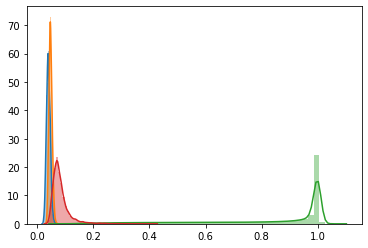

In [0]:
names = [layer.name for layer in model.layers
                   if 'flipout' in layer.name]
qm_vals = [layer.kernel_posterior.mean()
                     for layer in model.layers
                     if 'flipout' in layer.name]
qs_vals = [layer.kernel_posterior.stddev()
                     for layer in model.layers
                     if 'flipout' in layer.name]


    

for n, qs in zip(names, qs_vals):
    sns.distplot(tf.reshape(qs, shape=[-1]))
    

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive


In [0]:
def plot_heldout_prediction(input_vals, probs, fname, n=10,  title=''):

 
  fig = figure.Figure(figsize=(9, 3*n))
  canvas = backend_agg.FigureCanvasAgg(fig) 
  IMAGE_SHAPE = [28, 28, 1]
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation='None')

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title('posterior samples')

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), tf.reduce_mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('predictive probs')
  fig.suptitle(title)
  fig.tight_layout()

  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))


In [0]:
 print(' ... Running monte carlo inference')
probs = tf.stack([model.predict(X_test, verbose=1) for _ in range(50)], axis=0)
mean_probs = tf.reduce_mean(probs, axis=0)
heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
print(' ... Held-out nats: {:.3f}'.format(heldout_log_prob))
epoch=10
step=50
fname=os.path.join("/content/gdrive/My Drive",'epoch{}_step{}_pred.png'.format(epoch, step))
plot_heldout_prediction(X_test, probs, fname,title='mean heldout logprob {:.2f}' .format(heldout_log_prob))


saved /content/gdrive/My Drive/epoch10_step50_pred.png


In [0]:
n_mc_run = 100
y_pred_logits_list = [model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
from scipy.special import softmax
mean_prob_thres = 0.2
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:,:, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)
idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))
idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

In [0]:
import matplotlib.pyplot as plt
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()



True label of the test sample 583: 2


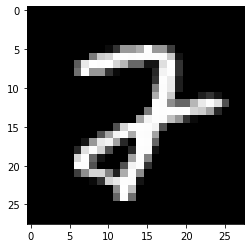

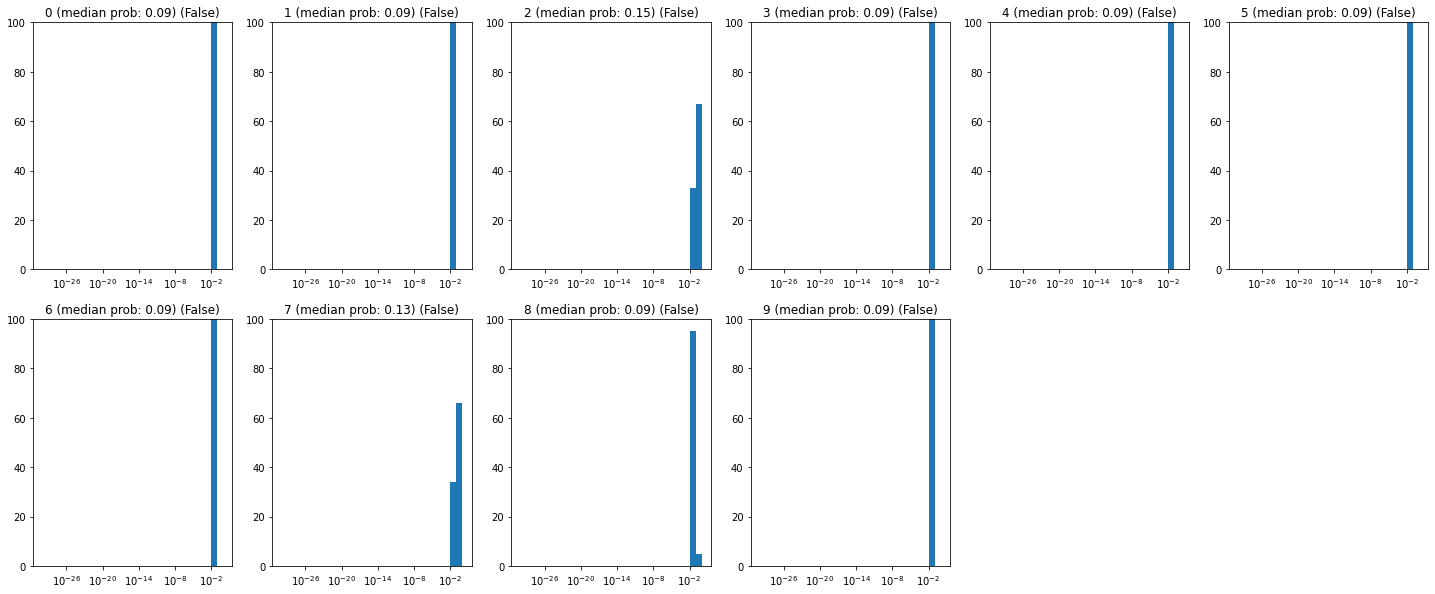

I don't know!


In [0]:
idx = 583
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")
